In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
width, height = 280, 560

In [3]:
def create_table():
    
    img = np.zeros((height,width,3), dtype=np.uint8) # create table image base
    img[:, :] = [0, 180, 10] # setting color to green pool table
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    

    cv2.circle(img, (int(width/2),int(height/5)), 
               int((width/3)/2), 
               (50,255,50)) 
    

    img[int(height/5):height,0:width] = [0, 180, 10] 
    cv2.line(img,(0,int(height/5)),(width,int(height/5)),(50,255,50)) 
    
    return img

In [4]:
def draw_holes(input_img, color3 = (200,140,0)):
        
    color = (190, 190, 190) # gray color
    color2 = (120, 120, 120) #  gray color, for circles (holes) on generated img

    img = input_img.copy() # make a copy of input image
    
    # borders 
    cv2.line(img,(0,0),(width,0),color3,3) # top
    cv2.line(img,(0,height),(width,height),color3,3) # bot
    cv2.line(img,(0,0),(0,height),color3,3) # left
    cv2.line(img,(width,0),(width,height),color3,3) # right
    
    # adding circles to represent holes on table
    cv2.circle(img, (0, 0), 11,color, -1) # top right
    cv2.circle(img, (width,0), 11, color, -1) # top left
    cv2.circle(img, (0,height), 11, color, -1) # bot left
    cv2.circle(img, (width,height), 11, color, -1) # bot right
    cv2.circle(img, (width,int(height/2)), 8, color, -1) # mid right
    cv2.circle(img, (0,int(height/2)), 8, color, -1) # mid left
    
    # adding another, smaller circles to the previous ones
    cv2.circle(img, (0, 0), 9,color2, -1) # top right
    cv2.circle(img, (width,0), 9, color2, -1) # top left
    cv2.circle(img, (0,height), 9, color2, -1) # bot left
    cv2.circle(img, (width,height), 9, color2, -1) # bot right
    cv2.circle(img, (width,int(height/2)), 6, color2, -1) # mid right
    cv2.circle(img, (0,int(height/2)), 6, color2, -1) # mid left
    
    return img

In [5]:
def draw_balls(ctrs,background = create_table(), radius=7, size = -1, img = 0):
    
    K = np.ones((3,3),np.uint8) # filter
    
    final = background.copy() # canvas
    mask = np.zeros((560, 280),np.uint8) # empty image, same size as 2d generated final output
    
    
    for x in range(len(ctrs)): # for all contours
        
        # find center of contour
        M = cv2.moments(ctrs[x])
        cX = int(M['m10']/M['m00']) # X pos of contour center
        cY = int(M['m01']/M['m00']) # Y pos
        
        # find color average inside contour
        mask[...]=0 # reset the mask for every ball 
        cv2.drawContours(mask,ctrs,x,255,-1) # draws mask for each contour
        mask =  cv2.erode(mask,K,iterations = 3) # erode mask several times to filter green color around balls contours
        
        
        # balls design:
        
        
        # circle to represent snooker ball
        final = cv2.circle(final, # img to draw on
                           (cX,cY), # position on img
                           radius, # radius of circle - size of drawn snooker ball
                           cv2.mean(img,mask), # color mean of each contour-color of each ball (src_img=transformed img)
                           size) # -1 to fill ball with color
        
        # add black color around the drawn ball (for cosmetics)
        final = cv2.circle(final, (cX,cY), radius, 0, 1) 
        
        # small circle for light reflection
        final = cv2.circle(final, (cX-2,cY-2), 2, (255,255,255), -1)
         
        

        
    return final

In [6]:
def filter_ctrs(ctrs, min_s = 90, max_s = 358, alpha = 3.445):  
    
    filtered_ctrs = [] # list for filtered contours
    
    for x in range(len(ctrs)): # for all contours
        
        rot_rect = cv2.minAreaRect(ctrs[x]) # area of rectangle around contour
        w = rot_rect[1][0] # width of rectangle
        h = rot_rect[1][1] # height
        area = cv2.contourArea(ctrs[x]) # contour area 

        
        if (h*alpha<w) or (w*alpha<h): # if the contour isnt the size of a snooker ball
            continue # do nothing
            
        if (area < min_s) or (area > max_s): # if the contour area is too big/small
            continue # do nothing 

        # if it failed previous statements then it is most likely a ball
        filtered_ctrs.append(ctrs[x]) # add contour to filtered cntrs list

        
    return filtered_ctrs

In [7]:
def find_balls(src):
    final = create_table()
    
    # warp perspective
    matrix = cv2.getPerspectiveTransform(pts1,pts2) # getting perspective by 4 points of each image
    transformed = cv2.warpPerspective(src, matrix, (width,height)) # warps perpective to new image

    # apply blur
    transformed_blur = cv2.GaussianBlur(transformed,(5,5),cv2.BORDER_DEFAULT) # blur applied
    blur_RGB = cv2.cvtColor(transformed_blur, cv2.COLOR_BGR2RGB) # rgb version

    # mask
    hsv = cv2.cvtColor(blur_RGB, cv2.COLOR_RGB2HSV) # convert to hsv
    mask = cv2.inRange(hsv, lower, upper) # table's mask

    # filter mask
    kernel = np.ones((5,5),np.uint8)
    mask_closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel) # dilate->erode
    
    # apply threshold
    ret,mask_inv = cv2.threshold(mask_closing,5,255,cv2.THRESH_BINARY_INV) # apply threshold
       
    # create image with masked objects on table 
    masked_objects = cv2.bitwise_and(transformed,transformed, mask=mask_inv) # masked image

    # find contours and filter them
    ctrs, hierarchy = cv2.findContours(mask_inv, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # find contours
    ctrs = filter_ctrs(ctrs) # filter contours by sizes and shapes

    # draw table+balls
    final = draw_balls(ctrs,radius=8,img=transformed) # draw all found contours  
    final = draw_holes(final) # draw holes
    
    return final

In [8]:
def find_ctrs_color(ctrs, input_img):
    
    K = np.ones((3,3),np.uint8) # filter
    output = input_img.copy() #np.zeros(input_img.shape,np.uint8) # empty img
    gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY) # gray version
    mask = np.zeros(gray.shape,np.uint8) # empty mask

    for i in range(len(ctrs)): # for all contours
        
        # find center of contour
        M = cv2.moments(ctrs[i])
        cX = int(M['m10']/M['m00']) # X pos of contour center
        cY = int(M['m01']/M['m00']) # Y pos
    
        mask[...]=0 # reset the mask for every ball 
    
        cv2.drawContours(mask,ctrs,i,255,-1) # draws the mask of current contour (every ball is getting masked each iteration)

        mask =  cv2.erode(mask,K,iterations=3) # erode mask to filter green color around the balls contours
        
        output = cv2.circle(output, # img to draw on
                         (cX,cY), # position on img
                         20, # radius of circle - size of drawn snooker ball
                         cv2.mean(input_img,mask), # color mean of each contour-color of each ball (src_img=transformed img)
                         -1) # -1 to fill ball with color
    return output

In [9]:
def draw_rectangles(ctrs, img):
    
    output = img.copy()
    
    for i in range(len(ctrs)):
    
        M = cv2.moments(ctrs[i]) # moments
        rot_rect = cv2.minAreaRect(ctrs[i])
        w = rot_rect[1][0] # width
        h = rot_rect[1][1] # height
        
        box = np.int64(cv2.boxPoints(rot_rect))
        cv2.drawContours(output,[box],0,(255,100,0),2) # draws box
        
    return output

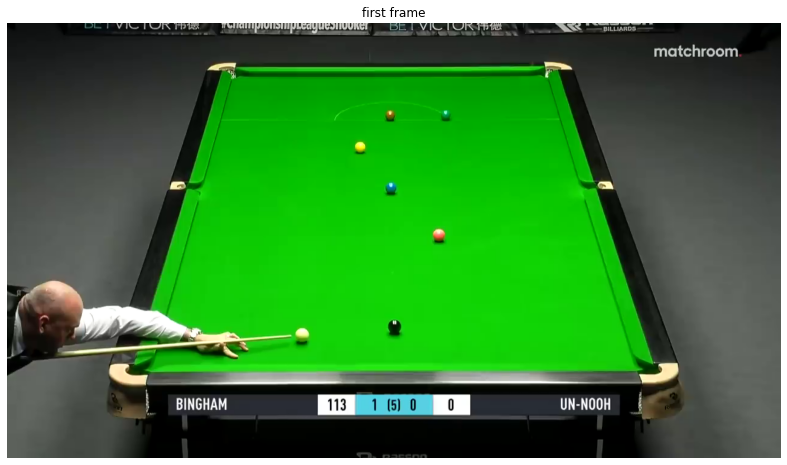

In [10]:
name = 'billiardVideo.mp4'

# first frame from the original video
cap = cv2.VideoCapture(name)
ret, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # take first frame

# loop frames and take few different frames for later
for i in range(1430):
    ret, frame2 = cap.read() # frame2 = the 1430th frame (frame example #1)
    if i == 1050:
        frame3 = frame2.copy() # frame3 = the 1000th frame (frame example #2)
    if i == 263:
        frame4 = frame2.copy() # frame4 = the 263th frame (frame example #3)
        
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB) 
frame3 = cv2.cvtColor(frame3, cv2.COLOR_BGR2RGB) 
frame4 = cv2.cvtColor(frame4, cv2.COLOR_BGR2RGB) # another frames

plt.figure(figsize=(16,8))
plt.imshow(frame)
plt.title('first frame')
plt.axis('off')
plt.show()

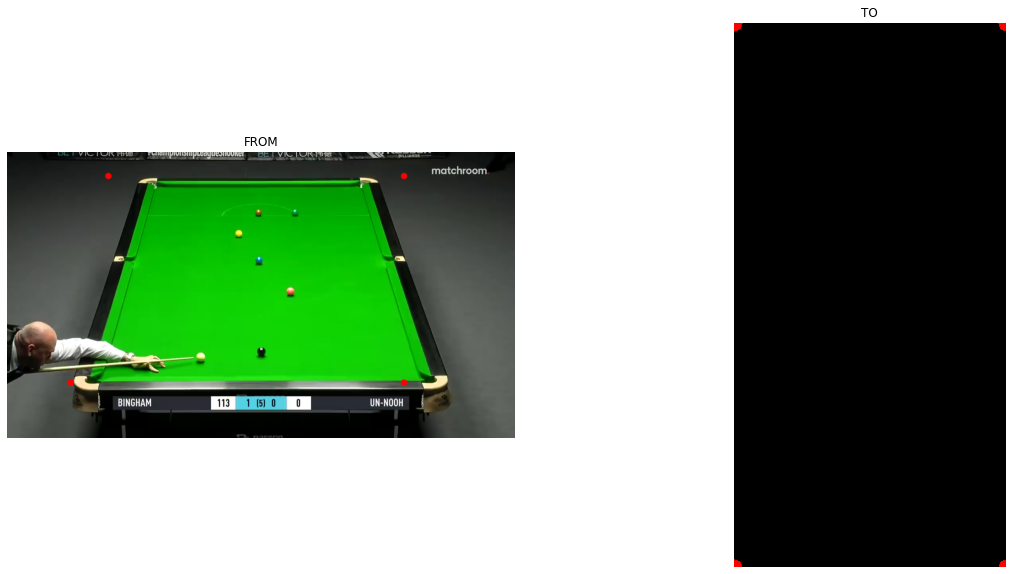

In [11]:
table = frame.copy() # add points to pool table corners
cv2.circle(table, (160, 580), 8, 255, -1) # bot left
cv2.circle(table, (1000, 580), 8, 255, -1) # bot right
cv2.circle(table, (255, 60), 8, 255, -1) # top left
cv2.circle(table, (1000, 60), 8, 255, -1) # top right

# red points on corners of generated table
img = np.zeros((height,width,3), dtype=np.uint8)
new_img = img.copy() # add points to edges of img
cv2.circle(new_img, (0,0), 8, 255, -1) # bot left
cv2.circle(new_img, (width,0), 8, 255, -1) # bot right
cv2.circle(new_img, (0,height), 8, 255, -1) # top left
cv2.circle(new_img, (width,height), 8, 255, -1) # top right

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(table)
plt.title('FROM')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(new_img)
plt.title('TO')
plt.axis('off')
plt.show()

In [12]:
pts1 = np.float32([ [255, 60],[1000, 60],[160, 580],[1000, 580] ]) # 4 corners points of ORIGINAL image
pts2 = np.float32([ [0,0],[width,0],[0,height],[width,height] ]) # 4 corners points of OUTPUT image

matrix = cv2.getPerspectiveTransform(pts1,pts2) # getting perspective by 4 points of each image
transformed = cv2.warpPerspective(frame, matrix, (width,height)) # warps perpective to new image

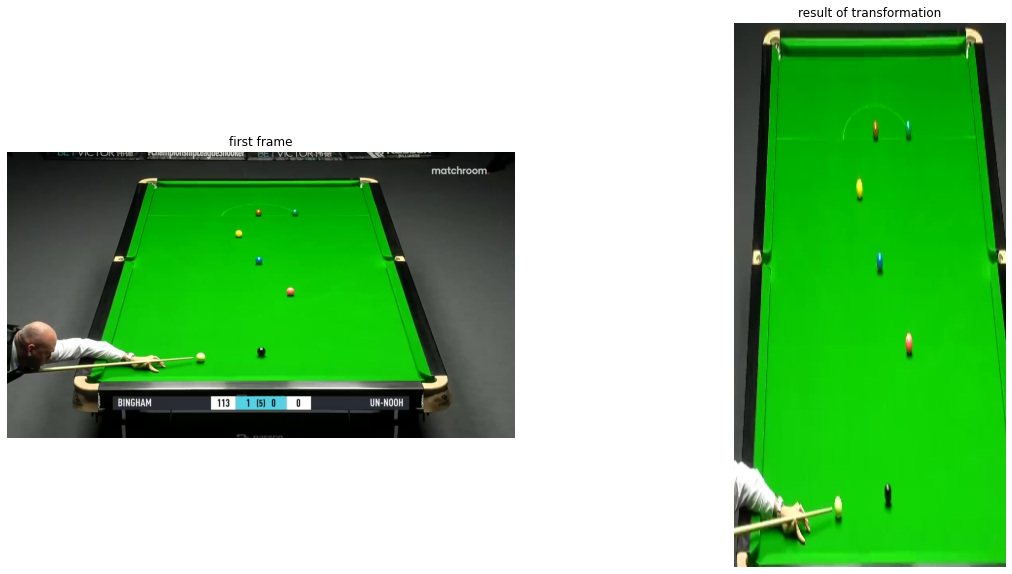

In [13]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('first frame')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(transformed)
plt.title('result of transformation')
plt.axis('off')
plt.show()

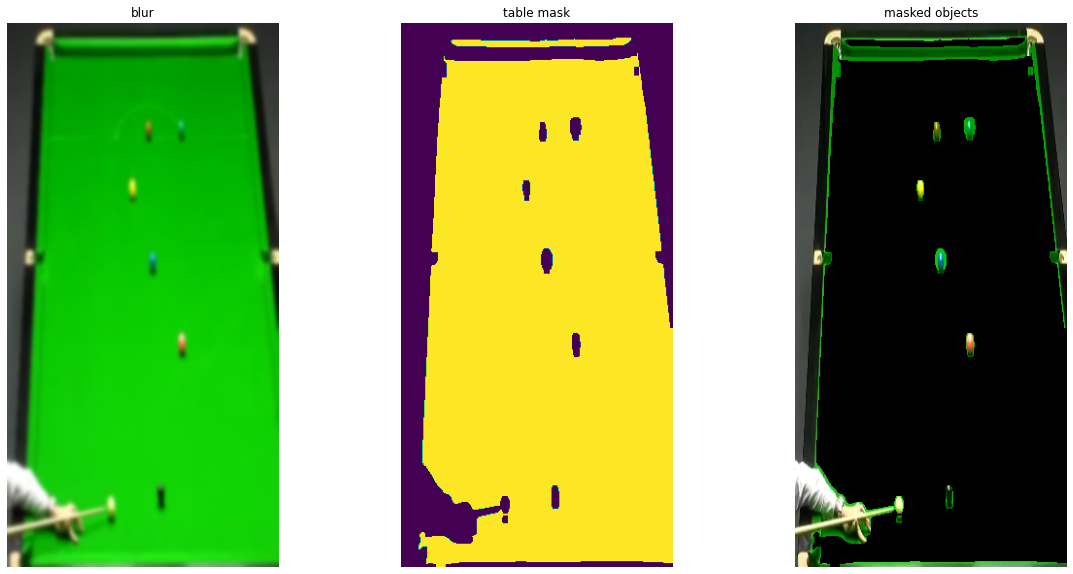

In [14]:
transformed_blur = cv2.GaussianBlur(transformed,(0,0),2) # blur applied
blur_RGB = cv2.cvtColor(transformed_blur, cv2.COLOR_BGR2RGB) # rgb version

# hsv colors of the snooker table
lower = np.array([60, 200,150]) 
upper = np.array([70, 255,240]) # HSV of snooker green: (60-70, 200-255, 150-240) 

hsv = cv2.cvtColor(blur_RGB, cv2.COLOR_RGB2HSV) # convert to hsv
mask = cv2.inRange(hsv, lower, upper) # table's mask

# apply closing
kernel = np.ones((5,5),np.uint8)
mask_closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel) # dilate->erode

# invert mask to focus on objects on table
_,mask_inv = cv2.threshold(mask_closing,5,255,cv2.THRESH_BINARY_INV) # mask inv

masked_img = cv2.bitwise_and(transformed,transformed, mask=mask_inv) # masked image with inverted mask

# plot edges, threshold, filter
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(transformed_blur)
plt.title('blur')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(mask_closing)
plt.title('table mask')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(masked_img) 
plt.title('masked objects')
plt.axis('off')
plt.show()

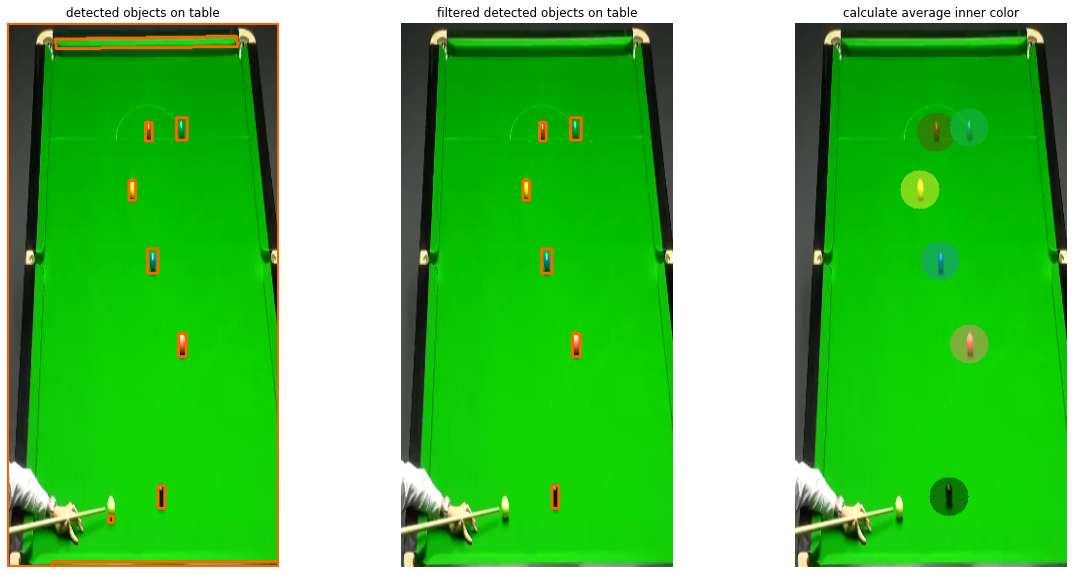

In [15]:
ctrs, hierarchy = cv2.findContours(mask_inv, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # create contours in filtered img

# draw contours before filter
detected_objects = draw_rectangles(ctrs, transformed) # detected objects will be marked in boxes

ctrs_filtered = filter_ctrs(ctrs) # filter unwanted contours (wrong size or shape)

# draw contours after filter
detected_objects_filtered = draw_rectangles(ctrs_filtered, transformed) # filtered detected objects will be marked in boxes

# find average color inside contours:
ctrs_color = find_ctrs_color(ctrs_filtered, transformed)
ctrs_color = cv2.addWeighted(ctrs_color,0.5,transformed,0.5,0) # contours color image + transformed image

# plot results
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(detected_objects)
plt.title('detected objects on table')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(detected_objects_filtered)
plt.title('filtered detected objects on table')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(ctrs_color)
plt.title('calculate average inner color')
plt.axis('off')
plt.show()

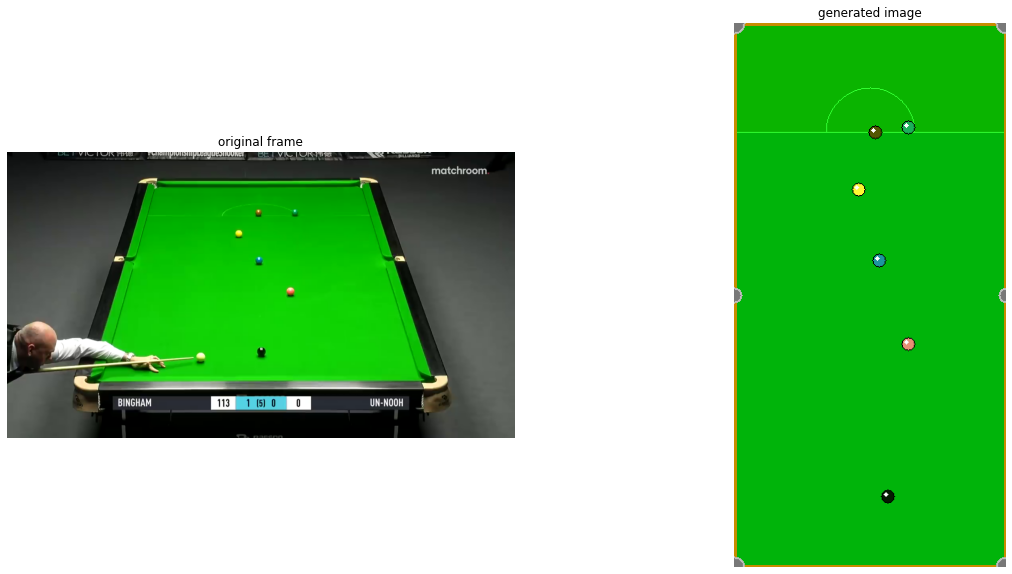

In [16]:
final = draw_balls(ctrs_filtered,img=transformed) # gets contours and draws balls in their centers
final = draw_holes(final) # draws holes in the 2D img

 
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original frame')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(final)
plt.title('generated image')
plt.axis('off')
plt.show()

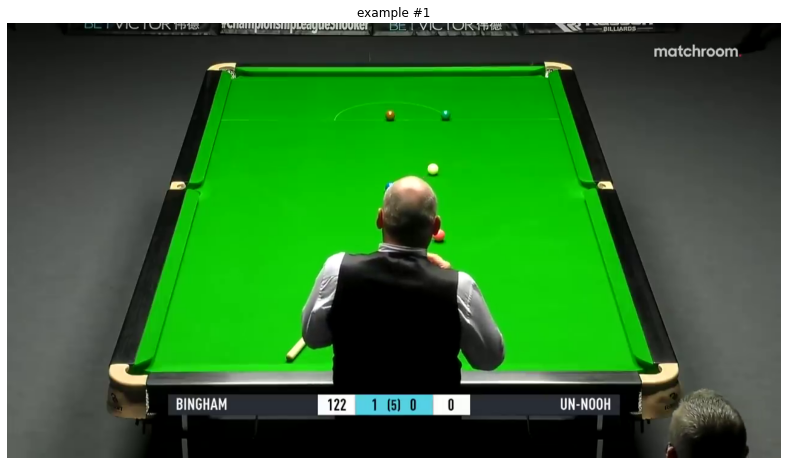

In [17]:
plt.figure(figsize=(16,8))
plt.imshow(frame2)
plt.title('example #1')
plt.axis('off')
plt.show()

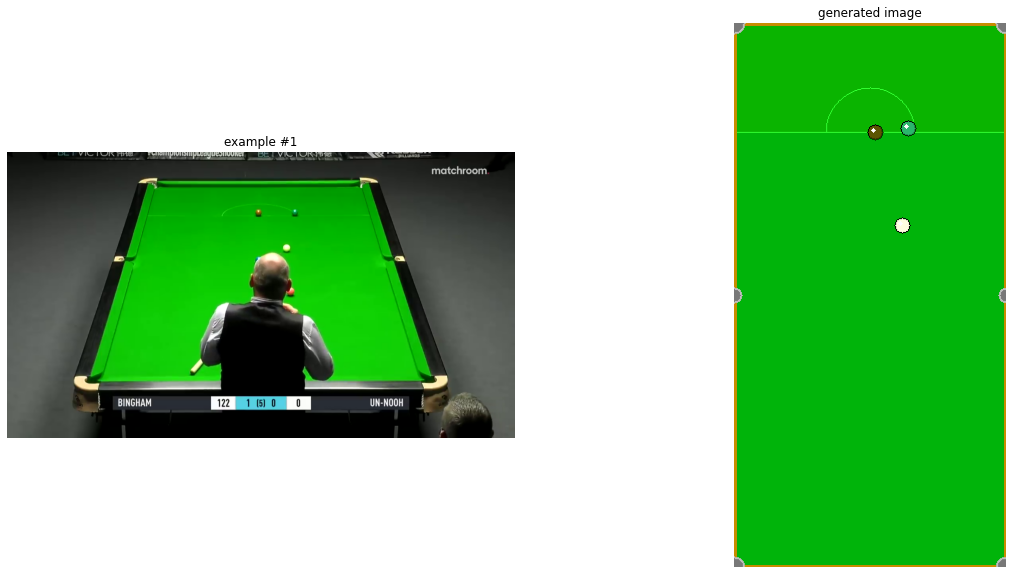

In [18]:
frame2_detect = find_balls(frame2) # find balls in frame2

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(frame2)
plt.title('example #1')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(frame2_detect)
plt.title('generated image')
plt.axis('off')
plt.show()

In [19]:
frame_zoom = frame[25:425,100:750] # zoom in on snooker table (resolution purposes)
scale_percent = 78 # = percent of original size

W = int((frame_zoom.shape[1] + (2 * width)) * scale_percent / 100) # final output width
H = int((img.shape[0]) * scale_percent / 100) # final output height
final_size = (W,H)

N = 80 # for adding borders to image 

# for text (2 types)
font_params = dict(org = (20,20),
                   fontFace = cv2.FONT_HERSHEY_DUPLEX,
                   fontScale = 0.7,
                   color = (255,255,255), # white color
                   lineType = 1)

font_params2 = dict(org = (20,20),
                   fontFace = cv2.FONT_HERSHEY_DUPLEX,
                   fontScale = 0.7,
                   color = (0,0,0), # black color
                   lineType = 1)


img = create_table() # creates green empty img to represent the 2D top view of the pool table 
frame_num = 0 # counting frames

# video
cap = cv2.VideoCapture('billiardVideo.mp4')

total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT) # get total frames amount
FPS = cap.get(cv2.CAP_PROP_FPS) # get FPS
fourcc = cv2.VideoWriter_fourcc(*'avc1') # get codec
out = cv2.VideoWriter('final_output_video.mp4',fourcc, FPS, final_size)

# for output (switching image)
flag_frames = [] # indexes of flag frames 
alpha = int(total_frames / 7)    
for i in range(7): 
    flag_frames.append(int(alpha*i%total_frames)) # takes 7 frames which will be flag frames for different images


ret ,frameOld = cap.read()
while(1):
    ret ,frameNew = cap.read()
    if ret == True:

        # zoom + border
        frame_zoom = frameNew[25:425,100:750] # zoom on table
        frameNew_border = cv2.copyMakeBorder(frame_zoom, N, N, 0, 0, cv2.BORDER_CONSTANT) # add borders from top and bot
        
        # warp perspective 
        matrix = cv2.getPerspectiveTransform(pts1,pts2) # getting perspective by both imgs points
        transformed = cv2.warpPerspective(frameNew, matrix, (width,height)) # warps perpectivess
        
        # blur
        transformed_blur = cv2.GaussianBlur(transformed,(5,5),cv2.BORDER_DEFAULT) # blur applied
        
        # mask
        hsv = cv2.cvtColor(transformed_blur, cv2.COLOR_RGB2HSV) # convert to hsv
        mask = cv2.inRange(hsv, lower, upper) # mask
        
        # filter mask
        kernel = np.ones((5,5),np.uint8)
        mask_closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel) # dilate->erode
        mask_rgb = cv2.cvtColor(mask_closing, cv2.COLOR_GRAY2RGB)
    
    
        # apply threshold
        ret,mask_inv = cv2.threshold(mask_closing,5,255,cv2.THRESH_BINARY_INV) # invert mask
       
        # create image with masked objects on table 
        masked_img = cv2.bitwise_and(transformed,transformed, mask=mask_inv) # masked image

        # find contours and filter them
        ctrs, hierarchy = cv2.findContours(mask_inv, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # find contours
        
        ctrs_img = draw_rectangles(ctrs,transformed) # detected objects img for output

        ctrs = filter_ctrs(ctrs) # filter contours by sizes and shapes

        ctrs_filt_img = draw_rectangles(ctrs,transformed) # filtered objects img for output

        ctrs_color = find_ctrs_color(ctrs,transformed) # image with colored contours
        ctrs_color = cv2.addWeighted(ctrs_color,0.5,transformed,0.5,0) # contours color image + transformed image
            
        # draw balls and holes
        top_view = draw_balls(ctrs,radius=8,img=transformed) # draw filtered contours (balls)  
        top_view = draw_holes(top_view,color3=(0,140,200)) # (RGB=>BGR)
        
        # adding text to output from previous steps of process
        cv2.putText(frameNew_border,'input', **font_params)
        cv2.putText(transformed,'warp perspective', **font_params)
        cv2.putText(transformed_blur,'blur', **font_params)
        cv2.putText(mask_rgb,'table mask', **font_params2)
        cv2.putText(masked_img,'masked image', **font_params)
        cv2.putText(ctrs_img,'detected objects', **font_params)
        cv2.putText(ctrs_filt_img, 'filtered objects', **font_params)
        cv2.putText(ctrs_color,'average inner color', **font_params)
        cv2.putText(top_view, 'output', **font_params)

        # use flag frames to switch output images:
        # every X frames the output image is going to switch to another one
        if (flag_frames[0] <= frame_num < flag_frames[1]):
            changing = transformed # warp perspective
        elif(flag_frames[1] < frame_num < flag_frames[2]):
            changing = transformed_blur # blur
        elif(flag_frames[2] < frame_num < flag_frames[3]):
            changing = mask_rgb # mask
        elif(flag_frames[3] < frame_num < flag_frames[4]):
            changing = masked_img # masked img
        elif(flag_frames[4] < frame_num < flag_frames[5]):
            changing = ctrs_img # contours
        elif(flag_frames[5] < frame_num < flag_frames[6]):
            changing = ctrs_filt_img # filtered contours
        elif(flag_frames[6] < frame_num):
            changing = ctrs_color # colored contours
        
        # concat and resize output
        final = cv2.hconcat([frameNew_border, changing])
        final = cv2.hconcat([final, top_view])
        final = cv2.resize(final, final_size, interpolation = cv2.INTER_AREA)

        cv2.imshow('final',final)
        out.write(final) # save final vid
        
        frame_num += 1 # frame counter ++
        k = cv2.waitKey(1) & 0xff 
        if k == 27:
            break
    else:
        break

cap.release() # release input video
out.release() # release output video 
cv2.destroyAllWindows() # delete output window
cv2.waitKey(1);

: 